# Лабораторная работа №2  
## Кластеризация данных (Bank Marketing)

В данной работе рассматривается задача кластеризации клиентов банка на основе датасета Bank Marketing.
Кластеризация относится к задачам обучения без учителя, поэтому целевая переменная `y` не используется
при обучении моделей.  

Цель работы — применить несколько методов кластеризации (KMeans, DBSCAN и Agglomerative Clustering),
сравнить полученные кластеры между собой, а также оценить их согласованность с истинными метками
классов при помощи внешних метрик качества.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score


In [2]:
data = pd.read_csv('bank-additional-full.csv', sep=';')


In [3]:
data.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


In [4]:
data.shape
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Датасет содержит информацию о клиентах банка и результатах маркетинговых кампаний.
Каждая строка соответствует одному клиенту. В таблице присутствуют как числовые,
так и категориальные признаки. Целевая переменная `y` указывает, оформил ли клиент
депозит, однако в данной работе она не будет использоваться при обучении моделей.


In [5]:
y_true = data['y']

X = data.drop(columns=['y'])

X.head()


,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0


Целевая переменная `y` была отделена от набора признаков и сохранена отдельно.
При обучении методов кластеризации она не используется, так как кластеризация
относится к задачам обучения без учителя. Истинные метки классов будут применяться
только на этапе оценки качества полученных кластеров.


In [6]:
X_encoded = pd.get_dummies(X, drop_first=True)

X_encoded.shape


(41188, 53)

Категориальные признаки были преобразованы с использованием One-Hot Encoding.
Данный подход позволяет корректно работать с категориальными данными в алгоритмах,
основанных на вычислении расстояний между объектами.


In [7]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded)


Так как методы кластеризации KMeans и DBSCAN чувствительны к масштабу признаков,
данные были стандартизированы с использованием StandardScaler.


In [8]:
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

X_pca.shape


(41188, 2)

In [9]:
pca.explained_variance_ratio_


array([0.09922477, 0.04593704])

Для снижения размерности данных и последующей визуализации был применён метод
главных компонент (PCA). Использованы две главные компоненты, что позволяет
отобразить данные в двумерном пространстве. Доля объяснённой дисперсии для
каждой компоненты приведена выше.


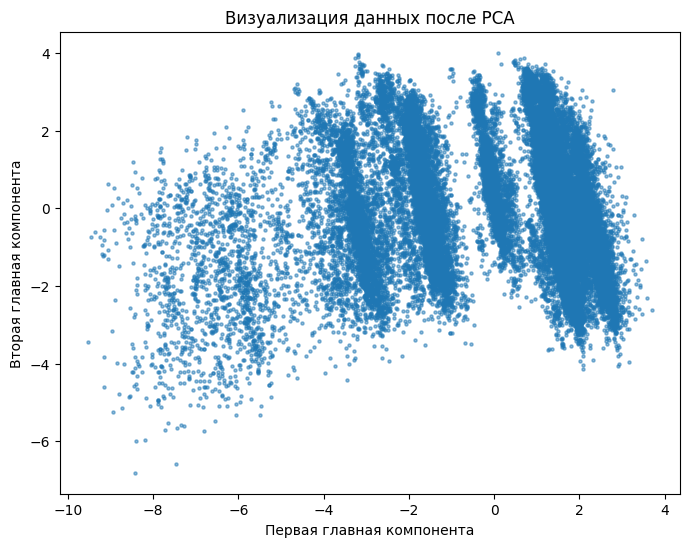

In [10]:
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=5, alpha=0.5)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Визуализация данных после PCA')
plt.show()


На визуализации в пространстве главных компонент наблюдаются вытянутые структуры
и значительное перекрытие данных. Чётко разделённых компактных кластеров не
наблюдается, что может свидетельствовать о сложной структуре данных и затруднять
задачу кластеризации.


In [11]:
from sklearn.metrics import silhouette_score

silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)


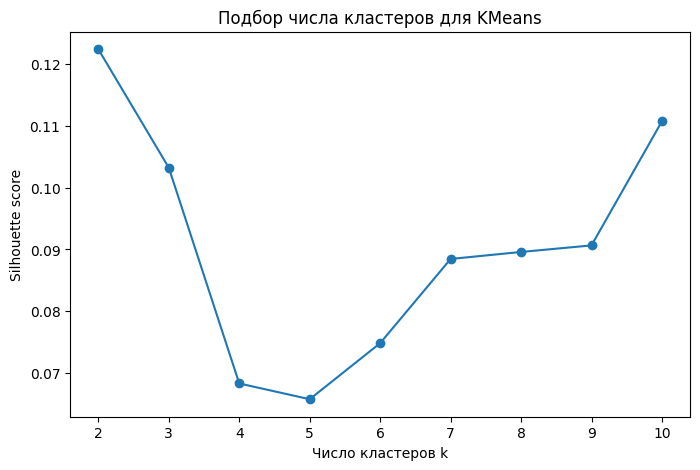

In [12]:
plt.figure(figsize=(8, 5))
plt.plot(K, silhouette_scores, marker='o')
plt.xlabel('Число кластеров k')
plt.ylabel('Silhouette score')
plt.title('Подбор числа кластеров для KMeans')
plt.show()


Для выбора оптимального числа кластеров в методе KMeans был использован коэффициент
силуэта. Значение k, при котором коэффициент силуэта максимален, рассматривается
как наиболее подходящее. Максимальное значение коэффициента силуэта достигается при k = 2.
В дальнейшем для метода KMeans будет использоваться данное количество кластеров.



In [13]:
kmeans = KMeans(n_clusters=2, random_state=42, n_init=10)
kmeans_labels = kmeans.fit_predict(X_scaled)


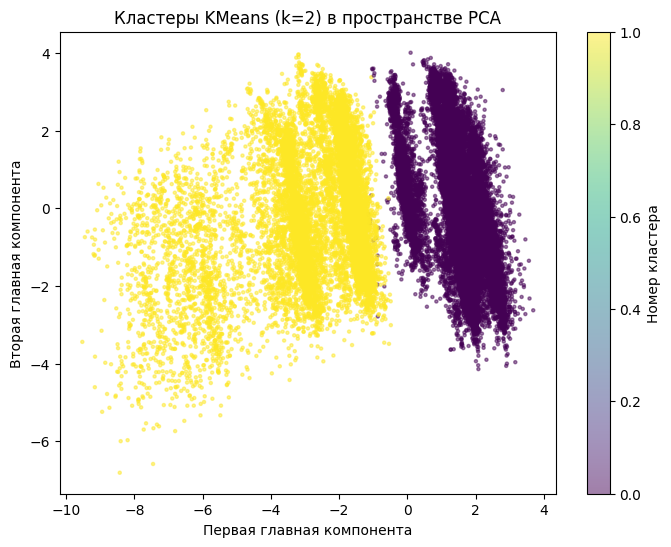

In [14]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=kmeans_labels, cmap='viridis',
    s=5, alpha=0.5
)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Кластеры KMeans (k=2) в пространстве PCA')
plt.colorbar(label='Номер кластера')
plt.show()


На визуализации кластеров, полученных методом KMeans, наблюдается частичное
разделение данных, однако кластеры значительно перекрываются. Это согласуется
с результатами PCA и указывает на сложную структуру данных.


In [15]:
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
y_encoded = le.fit_transform(y_true)


In [16]:
ari_kmeans = adjusted_rand_score(y_encoded, kmeans_labels)
nmi_kmeans = normalized_mutual_info_score(y_encoded, kmeans_labels)

ari_kmeans, nmi_kmeans


(0.1150103695056683, 0.07394459803989642)

Значения Adjusted Rand Index и Normalized Mutual Information для метода KMeans
оказались низкими, но отличными от нуля. Это указывает на слабое соответствие
полученных кластеров истинным меткам классов, что объясняется сложной структурой
данных и отсутствием чётко выраженных кластеров.


In [17]:
dbscan = DBSCAN(eps=1.5, min_samples=10)
dbscan_labels = dbscan.fit_predict(X_scaled)


In [19]:
unique_labels = np.unique(dbscan_labels)
unique_labels


array([ -1,   0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,
        12,  13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,
        25,  26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,
        38,  39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,
        51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,
        64,  65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,
        77,  78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,
        90,  91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102,
       103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115,
       116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128,
       129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141,
       142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154,
       155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
       168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 17

Метод DBSCAN позволяет выявлять кластеры произвольной формы, а также выделять
выбросы (объекты с меткой -1). Далее анализируется количество найденных кластеров
и доля объектов, отнесённых к шуму.


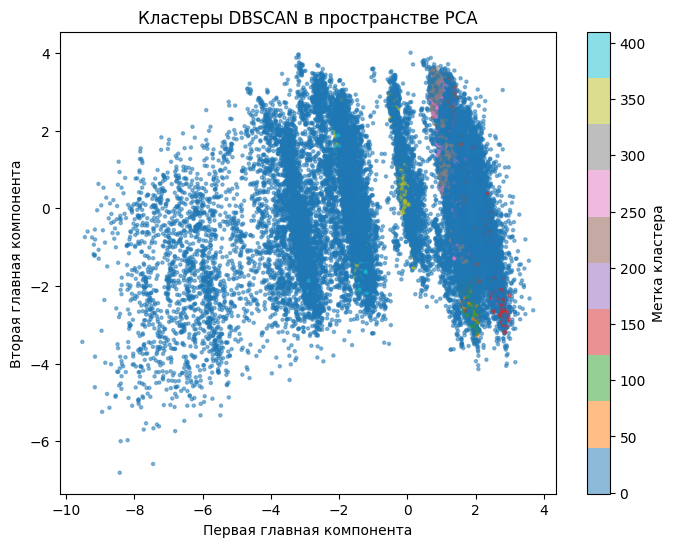

In [20]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=dbscan_labels, cmap='tab10',
    s=5, alpha=0.5
)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Кластеры DBSCAN в пространстве PCA')
plt.colorbar(label='Метка кластера')
plt.show()


Метод DBSCAN выявил большое количество малых кластеров и значительное число
объектов, отнесённых к шуму. Это свидетельствует о высокой неоднородности
плотности данных и чувствительности алгоритма DBSCAN к выбору параметров.
В данном случае метод оказался малопригоден для выявления осмысленной
кластерной структуры.


In [21]:
mask = dbscan_labels != -1

ari_dbscan = adjusted_rand_score(
    y_encoded[mask],
    dbscan_labels[mask]
)

nmi_dbscan = normalized_mutual_info_score(
    y_encoded[mask],
    dbscan_labels[mask]
)

ari_dbscan, nmi_dbscan


(-8.206799671209325e-10, 0.010748220344916654)

После исключения объектов, отнесённых к шуму, значения Adjusted Rand Index
оказались близкими к нулю, а Normalized Mutual Information — крайне малыми.
Это свидетельствует об отсутствии согласованности между кластерами,
выделенными методом DBSCAN, и истинными метками классов.


In [22]:
from sklearn.cluster import AgglomerativeClustering

agg = AgglomerativeClustering(n_clusters=2)
agg_labels = agg.fit_predict(X_scaled)


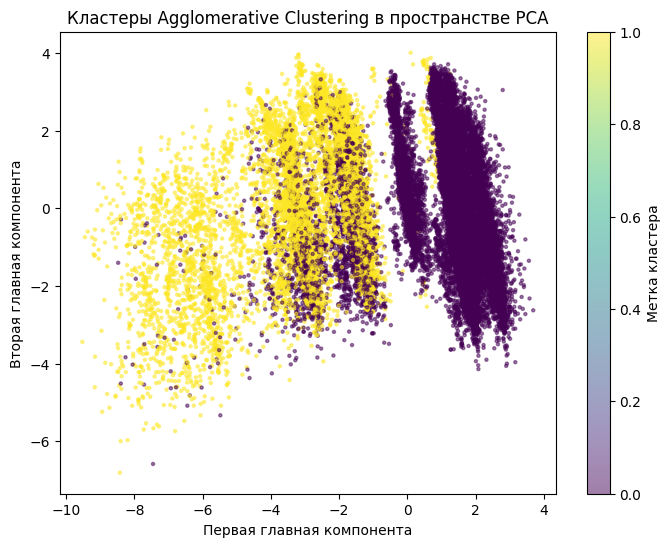

In [23]:
plt.figure(figsize=(8, 6))
plt.scatter(
    X_pca[:, 0], X_pca[:, 1],
    c=agg_labels, cmap='viridis',
    s=5, alpha=0.5
)
plt.xlabel('Первая главная компонента')
plt.ylabel('Вторая главная компонента')
plt.title('Кластеры Agglomerative Clustering в пространстве PCA')
plt.colorbar(label='Метка кластера')
plt.show()


In [24]:
ari_agg = adjusted_rand_score(y_encoded, agg_labels)
nmi_agg = normalized_mutual_info_score(y_encoded, agg_labels)

ari_agg, nmi_agg


(0.14987294469746737, 0.06190695427811073)

Метод иерархической кластеризации (Agglomerative Clustering) показал наилучшие
значения метрик согласованности с истинными метками среди рассмотренных методов.
Тем не менее, значения ARI и NMI остаются низкими, что указывает на слабое
соответствие кластерной структуры реальным классам и значительное перекрытие
данных.


### Сравнение методов кластеризации

| Метод                    | ARI     | NMI     |
|--------------------------|---------|---------|
| KMeans                   | ~0.115  | ~0.074  |
| DBSCAN                   | ~0.000  | ~0.011  |
| Agglomerative Clustering | ~0.150  | ~0.062  |

Наилучшее качество кластеризации продемонстрировал метод Agglomerative
Clustering. Метод DBSCAN оказался наименее эффективным для данного набора
данных из-за высокой неоднородности плотности и сложной структуры данных.


В рамках данной лабораторной работы были применены методы кластеризации KMeans,
DBSCAN и Agglomerative Clustering к данным банковского маркетинга. Для
визуализации использовалось понижение размерности методом PCA.

Результаты показали, что данные не содержат чётко выраженной кластерной
структуры. Все методы продемонстрировали низкое соответствие истинным меткам
классов, что объясняется значительным перекрытием признаков и сложной
социально-экономической природой данных.

Наиболее устойчивые результаты показал метод Agglomerative Clustering, однако
даже он не позволил получить высокое качество кластеризации.
